## Setting Data Directory

In [1]:
data_dir = '/kaggle/input/violence-nonviolence/Real_Life_Violence_Dataset'

## Setting Imports

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, LSTM, TimeDistributed, Input, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
import numpy as np
from matplotlib import pyplot as plt
import cv2

## Setting Constants

In [3]:
img_height, img_width= 100,100  
seed = 42
batch_size = 8
SEQUENCE_LEGNTH = 16
CLASS_LIST = ['Violence','NonViolence']

In [4]:
print(tf.__version__)

2.16.1


## Data Preprocessing

In [5]:
def extract_frames(video_path):
    
    frames = []
    video_reader = cv2.VideoCapture(video_path)
    total_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(total_frames//SEQUENCE_LEGNTH,1)
    
    for i in range(SEQUENCE_LEGNTH):
        
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, i * frame_interval)
        
        ret,frame = video_reader.read()
        if not ret:
            break
            
        resized_frame = cv2.resize(frame,(img_height,img_width))
        
        normalized_frame = resized_frame / 255.0
        
        frames.append(normalized_frame)
        
    video_reader.release()
    #print(f"Video File at {video_path} extracted into frames.")
    
    return frames
        

In [6]:
def create_dataset(max_vid_per_class = 750):
    
    features = []
    labels = []
    
    for class_index,class_name in enumerate(CLASS_LIST):
        
        print(f"Extracting Data of Class:{class_name}")
        
        files_list = os.listdir(os.path.join(data_dir,class_name))
        
        count = 0
        for filename in files_list:
            if count >= max_vid_per_class:
                break
            
            video_path = os.path.join(data_dir,class_name,filename)
            frames = extract_frames(video_path)
            
            if len(frames) == SEQUENCE_LEGNTH:
                
                features.append(frames)
                labels.append(class_index)
                count += 1
            
            #print(f"Extraction of {filename} into frames. Completed {count}/{max_vid_per_class}")
                
    features = np.asarray(features)
    labels = np.array(labels)
    
    return features, labels 

In [7]:
features,labels=create_dataset()

Extracting Data of Class:Violence
Extracting Data of Class:NonViolence


[h264 @ 0x5cb57249b880] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5cb57249b880] error while decoding MB 98 31
[h264 @ 0x5cb57249b880] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5cb57249b880] error while decoding MB 98 31
[h264 @ 0x5cb57249b880] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5cb57249b880] error while decoding MB 98 31
[h264 @ 0x5cb57249b880] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5cb57249b880] error while decoding MB 98 31


## Extracting features

### One Hot Encoding Labels

In [8]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [9]:
features_temp,features_test,labels_temp,labels_test = train_test_split(features, labels, 
                                                                        test_size=0.1,shuffle=True,
                                                                        random_state=seed)

In [10]:
features_train,features_val,labels_train,labels_val = train_test_split(features_temp, labels_temp, 
                                                                        test_size=0.2,shuffle=True,
                                                                        random_state=seed)

In [11]:
ohc_labels_train = to_categorical(labels_train)
ohc_labels_val = to_categorical(labels_val)
ohc_labels_test = to_categorical(labels_test)

## Creating the Xception Model + LSTM

In [12]:
base_model = Xception(
    include_top=False, 
    weights='imagenet', 
    input_shape=(100, 100, 3))

base_model.trainable = False

for layer in base_model.layers[-5:]:  
    layer.trainable = True

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten

model = Sequential()

model.add(Input(shape=(16, 100, 100, 3)))
model.add(TimeDistributed(base_model))    
model.add(Dropout(0.25))                    

model.add(TimeDistributed(GlobalAveragePooling2D()))

##Added LSTM to Capture the Sequencial Information
model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=False)))

# Dense Layer
model.add(Dense (128, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense (64, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(2,activation='softmax'))  
                     
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.build(input_shape=(None, 16, 100, 100, 3))


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ ?                      │    20,861,480 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 3,166,720 (12.08 MB)

 Non-trainable params: 17,694,760 (67.50 MB)

In [15]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [16]:
checkpoint_callback = ModelCheckpoint(
    filepath = 'xception_lstm.keras',
    save_weights_only = False,
    monitor='val_accuracy',
    mode = 'max',
    save_best_only = True
)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',  
                              factor=0.5,          
                              patience=7,          
                              min_lr=0.00001,         
                              verbose=1)
early_stop = EarlyStopping(
    monitor='val_loss',       
    patience=10,               
    restore_best_weights=True  
)

In [17]:
history = model.fit(x = features_train,
                    y = ohc_labels_train,
                    batch_size = batch_size,
                   epochs = 50,
                   validation_data = (features_val,ohc_labels_val),
                    shuffle=True,
                   callbacks=[checkpoint_callback,reduce_lr, early_stop])

Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 108s 396ms/step - accuracy: 0.6425 - loss: 0.6488 - val_accuracy: 0.8704 - val_loss: 0.3268 - learning_rate: 0.0010
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 39s 292ms/step - accuracy: 0.8658 - loss: 0.3838 - val_accuracy: 0.9037 - val_loss: 0.2691 - learning_rate: 0.0010
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 41s 303ms/step - accuracy: 0.8748 - loss: 0.3230 - val_accuracy: 0.9074 - val_loss: 0.2423 - learning_rate: 0.0010
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 40s 297ms/step - accuracy: 0.9250 - loss: 0.2220 - val_accuracy: 0.9148 - val_loss: 0.2207 - learning_rate: 0.0010
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 40s 294ms/step - accuracy: 0.9071 - loss: 0.2549 - val_accuracy: 0.8963 - val_loss: 0.2050 - learning_rate: 0.0010
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 40s 293ms/step - accuracy: 0.9477 - loss: 0.1456 - val_accuracy: 0.8741 - val_loss: 0.3104 - learning_rate: 0.0010
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 39s 293ms/step - accuracy: 0.

In [18]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label=metric_name_2)
    plt.title(str(plot_name))
    plt.legend()

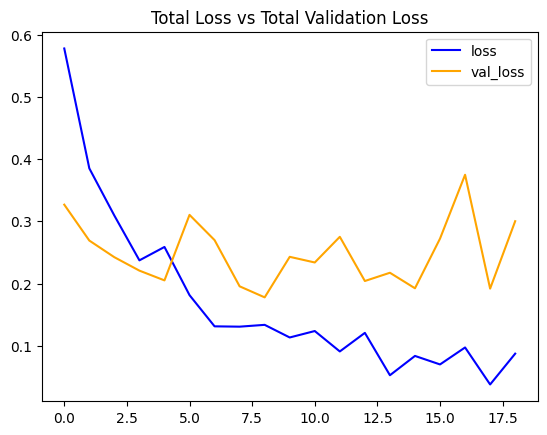

In [19]:
plot_metric(history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

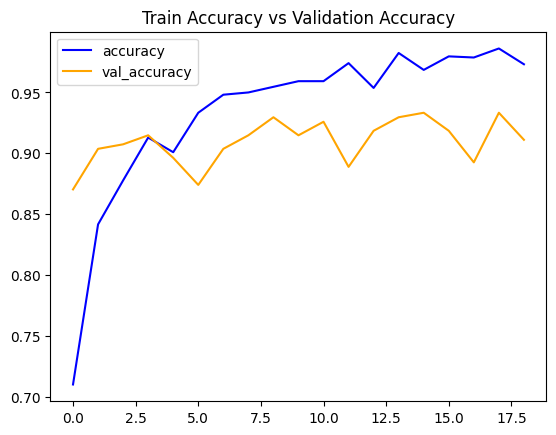

In [20]:
plot_metric(history, 'accuracy', 'val_accuracy', 'Train Accuracy vs Validation Accuracy')

In [21]:
model.save_weights('Xception_LSTM.weights.h5')

## Test

In [22]:
import time

In [23]:
print("labels_test shape:", labels_test.shape)
print("features_test shape:", features_test.shape)

labels_test shape: (150,)
features_test shape: (150, 16, 100, 100, 3)


In [24]:
start_time = time.perf_counter()
loss, accuracy = model.evaluate(features_test, ohc_labels_test)
end_time = time.perf_counter()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds")
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 646ms/step - accuracy: 0.8929 - loss: 0.2494
Elapsed time: 4.274344 seconds
Test Loss: 0.2448914796113968
Test Accuracy: 0.8999999761581421


In [25]:
labels_predict = model.predict(features_test)
labels_predict = np.argmax(labels_predict, axis=1)
labels_test_normal = np.argmax(ohc_labels_test, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step 


In [26]:
from sklearn.metrics import accuracy_score

AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.9


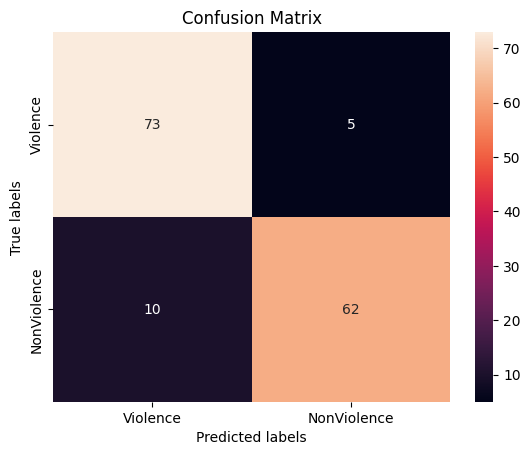

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax = plt.subplot()
cm = confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Violence', 'NonViolence'])
ax.yaxis.set_ticklabels(['Violence', 'NonViolence'])

plt.savefig('/kaggle/working/confusion_matrix.png', format='png', dpi=300, bbox_inches='tight')

plt.show()